In [3]:
!pip install scikit-learn
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.9 MB/s eta 0:00:00


Task 1

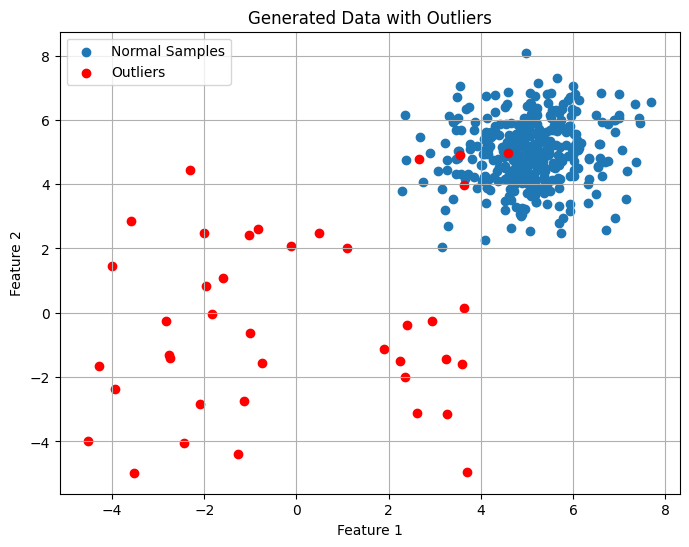

In [61]:
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

X_train, y_train, X_test, y_test = generate_data(
    n_train=400,
    n_test=100,
    n_features=2,
    contamination=0.1,
    random_state=1
)

normal_mask = (X_test == 0)
outlier_mask = (X_test == 1)

plt.figure(figsize=(8, 6))
plt.scatter(X_train[normal_mask][:, 0], X_train[normal_mask][:, 1], label='Normal Samples')
plt.scatter(X_train[outlier_mask][:, 0], X_train[outlier_mask][:, 1], color='red', label='Outliers')
plt.title('Generated Data with Outliers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

Task 2

In [62]:
from pyod.models.knn import KNN
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

contamination_rate = 0.1

clf = KNN(contamination=contamination_rate)

clf.fit(X_train)

y_train_pred = clf.predict(X_train)
y_train_scores = clf.decision_function(X_train)

y_test_pred = clf.predict(y_train)
y_test_scores = clf.decision_function(y_train)

Confusion Matrix:
[[90  0]
 [ 4  6]]

Balanced Accuracy: 0.8


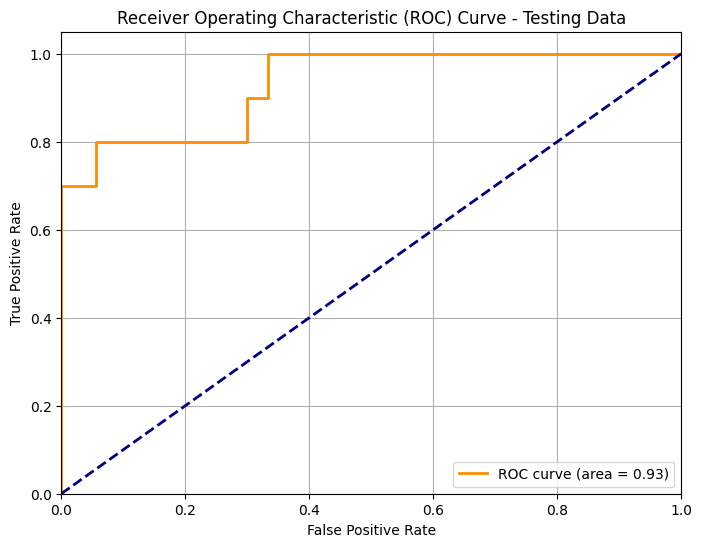

In [63]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nBalanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Testing Data')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Confusion Matrix:
[[357   3]
 [  4  36]]

Balanced Accuracy: 0.9458333333333333


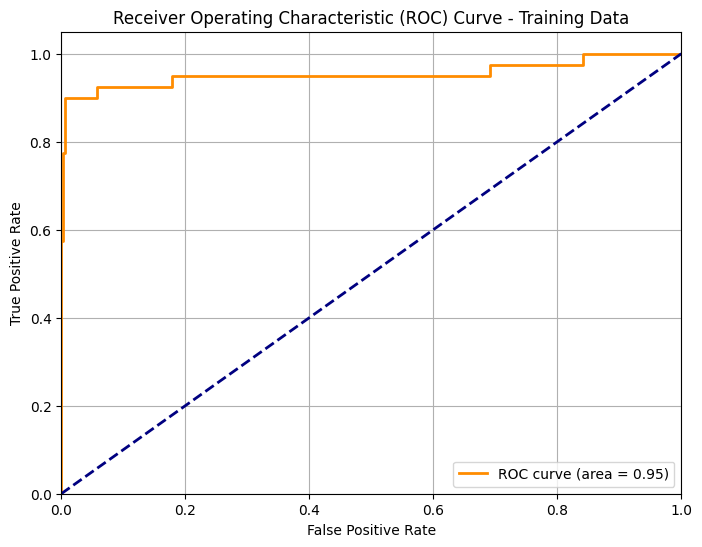

In [64]:
print("Confusion Matrix:")
print(confusion_matrix(X_test, y_train_pred))
print("\nBalanced Accuracy:", balanced_accuracy_score(X_test, y_train_pred))

fpr_train, tpr_train, thresholds_train = roc_curve(X_test, y_train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Task 3

In [65]:
from pyod.utils.data import generate_data
from scipy import stats
import numpy as np

n_train = 1000
n_test = 0
n_features = 1
contamination_rate = 0.1
random_state = 1

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features=n_features,
    contamination=contamination_rate,
    random_state=random_state
)

z_scores = stats.zscore(X_train)
abs_z_scores = np.abs(z_scores)

threshold = np.quantile(abs_z_scores, 1 - contamination_rate)

is_anomaly = abs_z_scores >= threshold
y_train_pred = np.where(is_anomaly, 1, 0)

print(f"Z-score threshold: {threshold}")
print(f"Number of detected anomalies: {y_train_pred.sum()}")

Z-score threshold: 1.181620873504838
Number of detected anomalies: 100


In [66]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

balanced_acc = balanced_accuracy_score(X_test, y_train_pred)

print("Balanced Accuracy:", balanced_acc)

Balanced Accuracy: 0.8055555555555556


Task 4

In [92]:
import numpy as np
from scipy.stats import multivariate_normal

mu = np.array([0, 0, 0])
Sigma = np.array([[1, 0.5, 0.2],
                  [0.5, 2, 0.8],
                  [0.2, 0.8, 3]])
n_samples = 500
x = np.random.randn(n_samples, mu.shape[0])
L = np.linalg.cholesky(Sigma)
y = (L @ x.T).T + mu

In [93]:
n_outliers = int(n_samples * contamination_rate)
np.random.seed(42)
outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)

y_with_outliers = y.copy()
outlier_shift_factor = 5
y_with_outliers[outlier_indices] += outlier_shift_factor * np.random.randn(n_outliers, mu.shape[0])

true_labels = np.zeros(n_samples, dtype=int)
true_labels[outlier_indices] = 1

print(f"Number of introduced outliers: {n_outliers}")

Number of introduced outliers: 50


In [98]:
mean_original = np.mean(y, axis=0)
cov_original = np.cov(y.T)
cov_original_inv = np.linalg.inv(cov_original)

diff = y_with_outliers - mean_original
mahalanobis_sq = np.sum((diff @ cov_original_inv) * diff, axis=1)

In [95]:
threshold_mahalanobis_sq = np.quantile(mahalanobis_sq, 1 - contamination_rate)

is_anomaly_mahalanobis = mahalanobis_sq >= threshold_mahalanobis_sq
predicted_labels_mahalanobis = np.where(is_anomaly_mahalanobis, 1, 0)

print(f"Mahalanobis distance squared threshold: {threshold_mahalanobis_sq}")
print(f"Number of detected anomalies (Mahalanobis): {predicted_labels_mahalanobis.sum()}")

Mahalanobis distance squared threshold: 10.764957408798933
Number of detected anomalies (Mahalanobis): 50


In [96]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

balanced_acc_mahalanobis = balanced_accuracy_score(true_labels, predicted_labels_mahalanobis)

print("Balanced Accuracy:", balanced_acc_mahalanobis)

conf_matrix_mahalanobis = confusion_matrix(true_labels, predicted_labels_mahalanobis)
print("Confusion Matrix:")
print(conf_matrix_mahalanobis)

Balanced Accuracy: 0.9333333333333333
Confusion Matrix:
[[444   6]
 [  6  44]]
